## import data

In [3]:
import pandas as pd
data = pd.io.stata.read_stata('../rawdata/dhs_survey_india/india_raw.dta', convert_categoricals=False)


In [4]:
#verifying no data was lost when importing
data.shape

(636699, 143)

In [5]:
assert data.shape == (636699, 143) 

## display data

In [6]:
data.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,sh72x,sh75,shnfhs2,shstruc,sv270s,sv271s,sv270us,sv271us,sv270rs,sv271rs
0,0100101305,IA7,113,5,1,113,196202,9,2019,1437,...,0,1,3.0,1,2,-80750,NaN,NaN,2.0,212400.0
1,0100101345,IA7,113,45,1,113,196202,9,2019,1437,...,0,1,3.0,1,2,110480,NaN,NaN,3.0,422510.0
2,0100101383,IA7,113,83,1,113,196202,9,2019,1437,...,0,1,3.0,1,2,131040,NaN,NaN,3.0,445090.0
3,0100101334,IA7,113,34,1,113,196202,9,2019,1437,...,0,1,2.0,1,1,-879110,NaN,NaN,1.0,-664740.0
4,0100101356,IA7,113,56,1,113,196202,9,2019,1437,...,0,1,3.0,2,3,333370,NaN,NaN,3.0,667379.0


In [7]:
#column names
itr = pd.read_stata('../rawdata/dhs_survey_india/india_raw.dta', iterator=True)
itr.variable_labels()

{'hhid': 'case identification',
 'hv000': 'country code and phase',
 'hv001': 'cluster number',
 'hv002': 'household number',
 'hv003': "respondent's line number (answering household questionnaire)",
 'hv004': 'ultimate area unit',
 'hv005': 'household sample weight (6 decimals)',
 'hv006': 'month of interview',
 'hv007': 'year of interview',
 'hv008': 'date of interview (cmc)',
 'hv008a': 'date of interview century day code (cdc)',
 'hv009': 'number of household members',
 'hv012': 'number of de jure members',
 'hv013': 'number of de facto members',
 'hv014': 'number of children 5 and under (de jure)',
 'hv015': 'result of household interview',
 'hv016': 'day of interview',
 'hv017': 'number of visits',
 'hv018': 'interviewer identification',
 'hv021': 'primary sampling unit',
 'hv022': 'sample strata for sampling errors',
 'hv023': 'stratification used in sample design',
 'hv024': 'state',
 'hv025': 'type of place of residence',
 'hv027': 'household selected for male interview',
 'hv

In [8]:
#identifying key columns we need
data_filtered = data.loc[0:636699,['hv001','hv270','hv271', 'hv009']]
data_filtered.head()

,hv001,hv270,hv271,hv009
0,113,3,-80750,5
1,113,3,110480,4
2,113,3,131040,5
3,113,1,-879110,5
4,113,3,333370,6


In [9]:
#ensuring we have all the required data
assert data_filtered.shape == (636699, 4) 

In [10]:
#renaming columns
data_filtered.rename(columns = {'hv001':'cluster_number', 'hv009':'number_household_members','hv270': 'wealth_index_combined', 'hv271': 'wealth_index_factor_score_combined' }, inplace = True)

## create new poverty column

In [11]:
#creating new column 'is_poor' where if wealth_index_comined <=2, considered poor
import numpy as np
data_filtered['is_poor'] = np.where(data['hv270']<=2, 1, 0)

## percentage of person affected by poverty per cluster

In [12]:
#identifying how many persons per cluster are affected by poverty
data_filtered['poor_number_household_members']= data_filtered['is_poor'] * data_filtered['number_household_members']

In [13]:
#grouping poor_number_household_members to clust
percentage_pov_head = data_filtered.groupby('cluster_number')['poor_number_household_members'].sum()

In [14]:
#creating headcount per cluster
head_count_cluster = data_filtered.groupby('cluster_number')['number_household_members'].sum()

In [15]:
data_filtered['percentage_pov_head'] = data_filtered.cluster_number.map(dict(percentage_pov_head/head_count_cluster))

## percentage of poverty in clusters according to households

In [16]:
percentage_pov_household = data_filtered.groupby('cluster_number')['is_poor'].sum()

In [17]:
percentage_pov_household_count = data_filtered.groupby('cluster_number')['wealth_index_combined'].count()

In [18]:
data_filtered['percentage_pov_household'] = data_filtered.cluster_number.map(dict(percentage_pov_household/percentage_pov_household_count))

## Calculating average_cluster_wealth_score

In [19]:
average_cluster_wealth_score = data_filtered.groupby('cluster_number')['wealth_index_factor_score_combined'].mean()

In [20]:
data_filtered['average_cluster_wealth_score']= data_filtered.cluster_number.map(dict(average_cluster_wealth_score))

## visualise data

In [21]:
data_filtered2 = data_filtered.loc[0:636699,['cluster_number','percentage_pov_head','percentage_pov_household', 'average_cluster_wealth_score']]

In [22]:
data_filtered2 = data_filtered2.drop_duplicates()

In [23]:
data_filtered2.shape

(30170, 4)

In [24]:
data_filtered2 = data_filtered2.sort_values("cluster_number")

## Merging GPS info to new dataframe

In [25]:
df_gps = pd.read_csv('../rawdata/dhs_survey_india/indiagpsinfo.csv')

In [26]:
data_filtered2.shape

(30170, 4)

In [27]:
df_gps.shape

(30197, 8)

In [28]:
data_filtered2

,cluster_number,percentage_pov_head,percentage_pov_household,average_cluster_wealth_score
862,101,0.660870,0.681818,-4.186812e+05
151,102,0.236220,0.227273,3.454866e+05
453,103,0.355769,0.363636,1.629703e+05
433,104,0.764228,0.750000,-6.710932e+05
260,105,1.000000,1.000000,-1.119339e+06
...,...,...,...,...
339074,93238,0.547619,0.636364,-4.512492e+05
339008,93239,0.780822,0.772727,-8.176677e+05
338527,93240,0.443182,0.500000,-2.034947e+05
339116,93241,0.882353,0.863636,-1.081512e+06


In [29]:
df_gps=df_gps.rename(columns = {'DHSCLUST':'cluster_number'})
df_gps

,cluster_number,ADM1DHS,ADM1NAME,DHSREGCO,DHSREGNA,URBAN_RURA,LATNUM,LONGNUM
0,101.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,U,34.382727,73.848621
1,102.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.404180,74.294310
2,103.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.455160,74.364586
3,104.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.559398,74.068008
4,105.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.457346,74.094578
...,...,...,...,...,...,...,...,...
30192,93238.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.191093,88.056766
30193,93239.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.395079,88.139663
30194,93240.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.205505,88.308991
30195,93241.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.097570,88.092668


In [31]:
df_final=df_gps.merge(data_filtered2, on='cluster_number', how='outer')
df_final

,cluster_number,ADM1DHS,ADM1NAME,DHSREGCO,DHSREGNA,URBAN_RURA,LATNUM,LONGNUM,percentage_pov_head,percentage_pov_household,average_cluster_wealth_score
0,101.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,U,34.382727,73.848621,0.660870,0.681818,-4.186812e+05
1,102.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.404180,74.294310,0.236220,0.227273,3.454866e+05
2,103.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.455160,74.364586,0.355769,0.363636,1.629703e+05
3,104.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.559398,74.068008,0.764228,0.750000,-6.710932e+05
4,105.0,1.0,JAMMU & KASHMIR,1.0,Kupwara,R,34.457346,74.094578,1.000000,1.000000,-1.119339e+06
...,...,...,...,...,...,...,...,...,...,...,...
30192,93238.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.191093,88.056766,0.547619,0.636364,-4.512492e+05
30193,93239.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.395079,88.139663,0.780822,0.772727,-8.176677e+05
30194,93240.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.205505,88.308991,0.443182,0.500000,-2.034947e+05
30195,93241.0,19.0,WEST BENGAL,932.0,Purba Barddhaman,R,23.097570,88.092668,0.882353,0.863636,-1.081512e+06


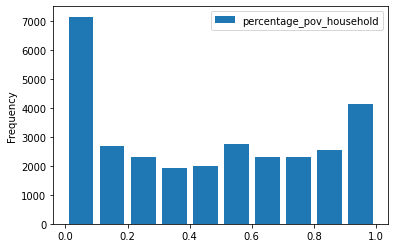

In [32]:
import matplotlib.pyplot as plt
df_final[['percentage_pov_household']].plot(kind='hist',rwidth=0.8)
plt.show()

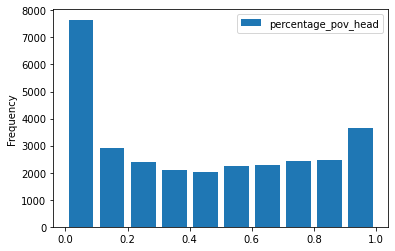

In [33]:
df_final[['percentage_pov_head']].plot(kind='hist',rwidth=0.8)
plt.show()

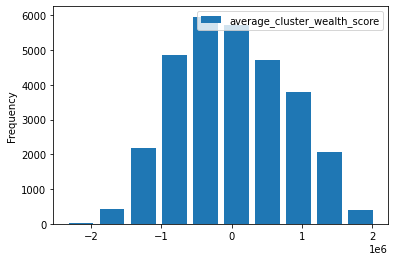

In [34]:
df_final[['average_cluster_wealth_score']].plot(kind='hist',rwidth=0.8)
plt.show()

<AxesSubplot:xlabel='percentage_pov_household', ylabel='Count'>

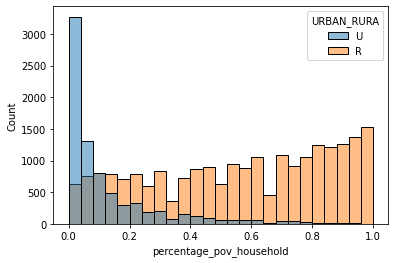

In [35]:
import seaborn as sns

sns.histplot(data=df_final, x="percentage_pov_household", hue="URBAN_RURA")

<AxesSubplot:xlabel='percentage_pov_head', ylabel='Count'>

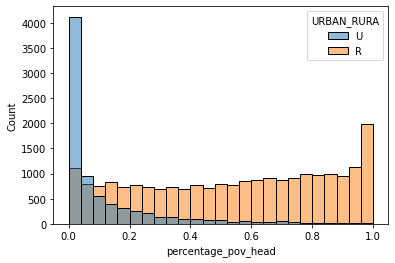

In [36]:
import seaborn as sns

sns.histplot(data=df_final, x="percentage_pov_head", hue="URBAN_RURA")

<AxesSubplot:xlabel='average_cluster_wealth_score', ylabel='Count'>

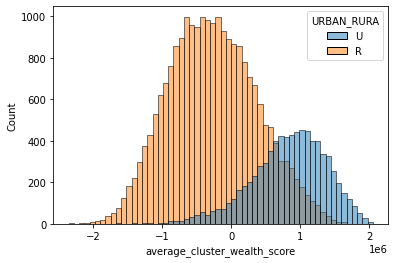

In [37]:
import seaborn as sns

sns.histplot(data=df_final, x="average_cluster_wealth_score", hue="URBAN_RURA")